In [40]:
genres = "Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,Game Show,History,Horror,Musical,Music,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western"
genres_list = genres.split(',')


### make an API request to IMDB site

In [5]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
pd.options.display.max_colwidth=200

import numpy as np
import itertools


In [6]:
def getSoup(url):
    """
    Utility function which takes a url and returns a Soup object.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    return soup

def minMax(a):
    '''Returns the index of negative and positive review.'''
    
    # get the index of least rated user review
    minpos = a.index(min(a))
    
    # get the index of highest rated user review
    maxpos = a.index(max(a))
    
    return minpos, maxpos

def getReviews(soup):
    '''Function returns a negative and positive review for each movie.'''
    
    # get a list of user ratings
    user_review_ratings = [tag.previous_element for tag in 
                           soup.find_all('span', attrs={'class': 'point-scale'})]
    
    
    # find the index of negative and positive review
    n_index, p_index = minMax(list(map(int, user_review_ratings)))
    
    
    # get the review tags
    user_review_list = soup.find_all('a', attrs={'class':'title'})
    
    
    # get the negative and positive review tags
    n_review_tag = user_review_list[n_index]
    p_review_tag = user_review_list[p_index]
    
    # return the negative and positive review link
    n_review_link = "https://www.imdb.com" + n_review_tag['href']
    p_review_link = "https://www.imdb.com" + p_review_tag['href']
    
    return n_review_link, p_review_link

def getReviewText(review_url):
    '''Returns the user review text given the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find div tags with class text show-more__control
    tag = soup.find('div', attrs={'class': 'text show-more__control'})
    
    return tag.getText()


def getRatingStars(review_url):
    '''Returns the star rating text given the review url.'''
    #print(review_url)
    # get the review_url's soup
    soup = getSoup(review_url)
    
    tag = soup.find('span', attrs={'class': 'point-scale'})
    
    try:
        tag = (soup.find('span', attrs={'class': 'point-scale'})).previous_sibling
    except:
        return '-1'

    return tag.getText()

def getMovieTitle(review_url):
    '''Returns the movie title from the review url.'''
    
    # get the review_url's soup
    soup = getSoup(review_url)
    
    # find h1 tag
    tag = soup.find('h1')
    
    return list(tag.children)[1].getText()

def getNounChunks(user_review):
    
    # create the doc object
    doc = nlp(user_review)
    
    # get a list of noun_chunks
    noun_chunks = list(doc.noun_chunks)
    
    # convert noun_chunks from span objects to strings, otherwise it won't pickle
    noun_chunks_strlist = [chunk.text for chunk in noun_chunks]
    
    return noun_chunks_strlist

### 1. make API request to get 250 movie titles

In [7]:
# API call to select:
## feature films
## which are rated atleast 4.0
## having atleast 50,000 votes
## in the Thriller genre
## sorted by user rating
## limit to 250 movies
url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=1.0,10.0&num_votes=1000,&genres=thriller&view=simple&sort=release_date,desc&count=250'''

# get the soup object for main api url
movies_soup = getSoup(url)

### 2. scrape the result and extract movie links

In [8]:
# find all a-tags with class:None
movie_tags = movies_soup.find_all('a', attrs={'class': None})

# filter the a-tags to get just the titles
movie_tags = [tag.attrs['href'] for tag in movie_tags 
              if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')]

# remove duplicate links
movie_tags = list(dict.fromkeys(movie_tags))

print("There are a total of " + str(len(movie_tags)) + " movie titles")
print("Displaying 10 titles")
movie_tags[:10]


There are a total of 250 movie titles
Displaying 10 titles


['/title/tt11499506/',
 '/title/tt9110340/',
 '/title/tt9340860/',
 '/title/tt10736580/',
 '/title/tt10127684/',
 '/title/tt10840884/',
 '/title/tt8004664/',
 '/title/tt11284280/',
 '/title/tt2235695/',
 '/title/tt12882620/']

### 3. extract user reviews for each title

In [9]:
# movie links
base_url = "https://www.imdb.com"
movie_links = [base_url + tag + 'reviews' for tag in movie_tags]
print("There are a total of " + str(len(movie_links)) + " movie user reviews")
print("Displaying 10 user reviews links")
movie_links[:10]

There are a total of 250 movie user reviews
Displaying 10 user reviews links


['https://www.imdb.com/title/tt11499506/reviews',
 'https://www.imdb.com/title/tt9110340/reviews',
 'https://www.imdb.com/title/tt9340860/reviews',
 'https://www.imdb.com/title/tt10736580/reviews',
 'https://www.imdb.com/title/tt10127684/reviews',
 'https://www.imdb.com/title/tt10840884/reviews',
 'https://www.imdb.com/title/tt8004664/reviews',
 'https://www.imdb.com/title/tt11284280/reviews',
 'https://www.imdb.com/title/tt2235695/reviews',
 'https://www.imdb.com/title/tt12882620/reviews']

### 4. for each move get a positive and a negative review link

In [10]:
# get a list of soup objects
movie_soups = [getSoup(link) for link in movie_links]

# get all 500 movie review links
movie_review_list = [getReviews(movie_soup) for movie_soup in movie_soups]

movie_review_list = list(itertools.chain(*movie_review_list))
print(len(movie_review_list))

print("There are a total of " + str(len(movie_review_list)) + " individual movie reviews")
print("Displaying 10 reviews")
movie_review_list[:10]

500
There are a total of 500 individual movie reviews
Displaying 10 reviews


['https://www.imdb.com/review/rw6317615/',
 'https://www.imdb.com/review/rw6317151/',
 'https://www.imdb.com/review/rw6320840/',
 'https://www.imdb.com/review/rw6305364/',
 'https://www.imdb.com/review/rw6269335/',
 'https://www.imdb.com/review/rw6236463/',
 'https://www.imdb.com/review/rw6223075/',
 'https://www.imdb.com/review/rw6244347/',
 'https://www.imdb.com/review/rw6221933/',
 'https://www.imdb.com/review/rw6255742/']

### 5. create a dataframe from all the reviews

In [11]:
# get review text from the review link
review_texts = [getReviewText(url) for url in movie_review_list]

ratings_star =  [getRatingStars(url) for url in movie_review_list]

# get movie name from the review link
movie_titles = [getMovieTitle(url) for url in movie_review_list]

# label each review with negative=0 or positive=1
#review_sentiment = np.array([0, 1] * (len(movie_review_list)//2))

# construct a dataframe
df = pd.DataFrame({'movie': movie_titles, 'user_review_permalink': movie_review_list,
             'text': review_texts, 'sentiment': ratings_star})

In [12]:
df.head()

,movie,user_review_permalink,text,sentiment
0,The Beast,https://www.imdb.com/review/rw6317615/,This movie was absolutely one of the worst movies i have seen. This movie was bad in all areas starting from actors.,1
1,The Beast,https://www.imdb.com/review/rw6317151/,"Do not fall for stupid reviews. This is an amazing movie. A short, crisp and meaningful plot. People expected this guy to fight like a superhuman. But the fact is that he had PTSD. He had panic at...",9
2,Andhaghaaram,https://www.imdb.com/review/rw6320840/,Nothing but movie is for waste 2:50 hrs of ur life,1
3,Andhaghaaram,https://www.imdb.com/review/rw6305364/,"Felt like watching a DC movie in Tamil. Runtime may appear to be a bit long. But if you sit tight and get through the first hour, it'll be an unforgettable movie. Wise choice of actors. Specially ...",10
4,Let Him Go,https://www.imdb.com/review/rw6269335/,"Simple plot with too many side stories. Who's the Indian boy? Just shows up, for what purpose? The Costner character was a lawman, why didn't he use the law to get the kid back? No husband would l...",5


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   movie                  500 non-null    object
 1   user_review_permalink  500 non-null    object
 2   text                   500 non-null    object
 3   sentiment              500 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


### 6. set the correct sentiment labels

In [20]:
# for r in df:
#     if df['sentiment'] == -1:
#         pass
#     elif df['sentiment'] <= 4:
#         df['sentiment'] = 0
#     else:
#         df['sentiment'] = 1
        
df = df[df.sentiment != -1]

### 7. save the dataframe

In [15]:
test_data_dir = 'test_data/imdb/scraped_data.csv'

df.to_csv(test_data_dir, index = False)
print("Saved dataset to: ", test_data_dir)

Saved dataset to:  test_data/imdb/scraped_data.csv


### 8. load dataframe and check contents

In [21]:

test_data_dir = 'test_data/imdb/scraped_data.csv'

print("Loading previously saved dataset from:\t", test_data_dir)
dtypes = {'sentiment': 'int', 'text': 'str'}
df = pd.read_csv(test_data_dir,dtype=dtypes) 


Loading previously saved dataset from:	 test_data/imdb/scraped_data.csv


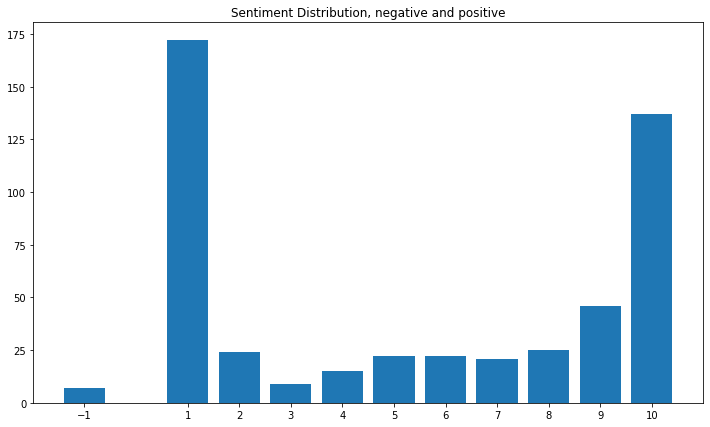

In [27]:
import matplotlib.pyplot as plt
val_count = df.sentiment.value_counts()

plt.figure(figsize=(12,7))
plt.bar(val_count.index, val_count.values)
plt.xticks(val_count.index)
plt.title("Sentiment Distribution, negative and positive")
plt.show()

In [ ]:
df.info()

In [6]:
from manny_modules import data_loading as process

# drop un-needed columns
df = df.drop(['user_review_permalink', 'movie'], axis=1) 

In [7]:
from manny_modules import normalize_dataset as nd

df = nd.clean_and_return(df,'text')

In [8]:
df.head()

,text,sentiment
0,dark yes complex ambitious christopher nolan and his cowriter jonathan nolan deserve a standing ovation i don't usually go for loud movies filled with mindless gore and violence the dark kni...,0
1,confidently directed dark brooding and packed with impressive action sequences and a complex story the dark knight includes a careerdefining turn from heath ledger as well as other oscar worth...,1
2,i have to say to make such an impressive trailer and such an uninteresting film takes some doing here you have most of the elements that would make a very good film you have great special effect...,0
3,my rd time watching this movie yet it still stunned my mind kept me enjoyed its every moment and left me with many thoughts afterward for someone like me who've rarely slept without dream it...,1
4,there is no shortage of films that depict the injustice of social inequality but originality is scarce with a large proportion of its population below the poverty line it is noteworthy that a fi...,0


### save as test data set

In [23]:
test_data_unseen = 'imdb_dataset/test_data_unseen.csv'

df.to_csv(test_data_unseen, index = False)
print("Saved dataset to: ", test_data_unseen)

print("Loading previously saved dataset from:\t", test_data_unseen)
dtypes = {'sentiment': 'int', 'text': 'str'}
df = pd.read_csv(test_data_unseen,dtype=dtypes) 
#drop and Nan rows if any
df = df.dropna() 

# save again after dropping NaNs from set
df.to_csv(test_data_unseen, index = False)
print("Saved dataset to: ", test_data_unseen)

Saved dataset to:  imdb_dataset/test_data_unseen.csv


In [14]:
# from bs4 import BeautifulSoup

# url_test = "https://www.imdb.com/review/rw6056008/"


    
# # get the review_url's soup
# soup = getSoup(url_test)
# # find div tags with class text show-more__control
# tag = soup.find('span', attrs={'class': 'point-scale'})

# try:
#     tag = (soup.find('span', attrs={'class': 'point-scale'})).previous_sibling
# except:
#     print("NoneType error")

